# Neural Tangent Kernel Analysis with Finite Width and Depth

This notebook implements a Poisson PDE solver using neural networks with configurable activation functions, and analyzes the NTK behavior.

## 1. Setup and Imports
Make sure to run `pip install -r requirements.txt` before running this notebook.

In [1]:
import sys
import os
import jax
import jax.numpy as jnp
import neural_tangents as nt
from neural_tangents import stax
from jax import grad, jacfwd, vmap
import numpy as np
import time

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import optax

from typing import Any, Callable, Sequence, Optional, Union

In [2]:
# importing the analyzer class
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from util.ntk_analyzer import NTKAnalyzer
from util.helper import create_mlp_stax

In [3]:
# True solution and source term
# u(x,y) = sin(pi x) sin(pi y)
# ∇²u = f, so f = -2 π² sin(pi x) sin(pi y)

def u_true(xy):
    x, y = xy
    return jnp.sin(jnp.pi * x) * jnp.sin(jnp.pi * y)

def f_source(xy):
    x, y = xy
    return -2 * (jnp.pi ** 2) * jnp.sin(jnp.pi * x) * jnp.sin(jnp.pi * y)

In [4]:
INPUT_DIM = 2
OUTPUT_DIM = 1

HIDDEN_LAYERS = 1
HIDDEN_WIDTH = 2**7
ACTIVATION_FN_STAX = stax.Erf()

# for init of weights
W_STD = 1.5            
B_STD = 0.05

# Network Hyperparameters
init_fn, apply_fn, net_stax_kernel_fn = create_mlp_stax(
    depth=HIDDEN_LAYERS, 
    hidden_width=HIDDEN_WIDTH,
    output_dim=OUTPUT_DIM,
    activation_stax_fn=ACTIVATION_FN_STAX,
    W_std=W_STD,
    b_std=B_STD
)

# Initialize params
key = jax.random.PRNGKey(0)
_, init_params = init_fn(key, (-1, INPUT_DIM))

In [5]:
def laplacian_u_stax(params, coords):
    u_fn = lambda z: apply_fn(params, z).squeeze()
    grad_u_hat_fn = jax.grad(u_fn)
    hessian_fn = jax.jacfwd(grad_u_hat_fn)
    hessian = hessian_fn(coords)
    return jnp.trace(hessian)

# Residual at point xy
def pde_residual_stax(params, coords):
    return laplacian_u_stax(params, coords) - f_source(coords)

In [6]:
# Loss computation
boundary_loss_weight = 100.0 # Hyperparameter to balance PDE and boundary losses

def compute_total_loss(params, interior_pts, boundary_pts):
    pde_vals = vmap(lambda pt: pde_residual_stax(params, pt))(interior_pts)
    loss_pde = jnp.mean(pde_vals**2)

    u_boundary = vmap(lambda pt: apply_fn(params, pt))(boundary_pts)
    loss_bc = jnp.mean(u_boundary**2)

    return loss_pde + boundary_loss_weight * loss_bc

# Optimizer
tx = optax.adam(1e-3)
opt_state = tx.init(init_params)

@jax.jit
def train_step_stax(params, opt_state, interior_pts, boundary_pts):
    def loss_fn(p):
        # compute_total_loss already returns a scalar, no squeeze needed.
        return compute_total_loss(p, interior_pts, boundary_pts)
    
    loss_val, grads = jax.value_and_grad(loss_fn)(params)
    updates, new_opt_state = tx.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, loss_val

In [7]:
# Sample points for the 
n_int = 1000    # Number of interior collocation points
n_bnd_side = 500 # Number of boundary points per side
key, k_int, k_bnd_y, k_bnd_x = jax.random.split(key, 4) # New keys

# Sample interior points (domain: unit square [0,1]x[0,1])
interior_points = jax.random.uniform(k_int, (n_int, 2), minval=0., maxval=1.)

# Sample boundary points
rand_ys_for_x_sides = jax.random.uniform(k_bnd_y, (n_bnd_side, 1), minval=0., maxval=1.)
rand_xs_for_y_sides = jax.random.uniform(k_bnd_x, (n_bnd_side, 1), minval=0., maxval=1.)

boundary_points = jnp.vstack([
    jnp.hstack([jnp.zeros((n_bnd_side, 1)), rand_ys_for_x_sides]),   # x=0 edge
    jnp.hstack([jnp.ones((n_bnd_side, 1)), rand_ys_for_x_sides]),    # x=1 edge
    jnp.hstack([rand_xs_for_y_sides, jnp.zeros((n_bnd_side, 1))]),   # y=0 edge
    jnp.hstack([rand_xs_for_y_sides, jnp.ones((n_bnd_side, 1))])     # y=1 edge
])

In [8]:
layer_widths_spec = [INPUT_DIM] + [HIDDEN_WIDTH] * HIDDEN_LAYERS + [OUTPUT_DIM]

# Let us analyze some NTK
analyzer_initial = NTKAnalyzer(
    apply_fn=apply_fn, 
    params=init_params,
    depth=HIDDEN_LAYERS, 
    widths=layer_widths_spec
)

beta_value = analyzer_initial.get_beta()
print(f"Calculated Beta (sum 1/n_j for hidden layers): {beta_value if beta_value is not None else 'N/A'}")

Calculated Beta (sum 1/n_j for hidden layers): 0.0078125



--- Initial Empirical NTK Analysis (on 200 training points) ---
Shape of Empirical NTK K(X,X): (200, 200, 1, 1)


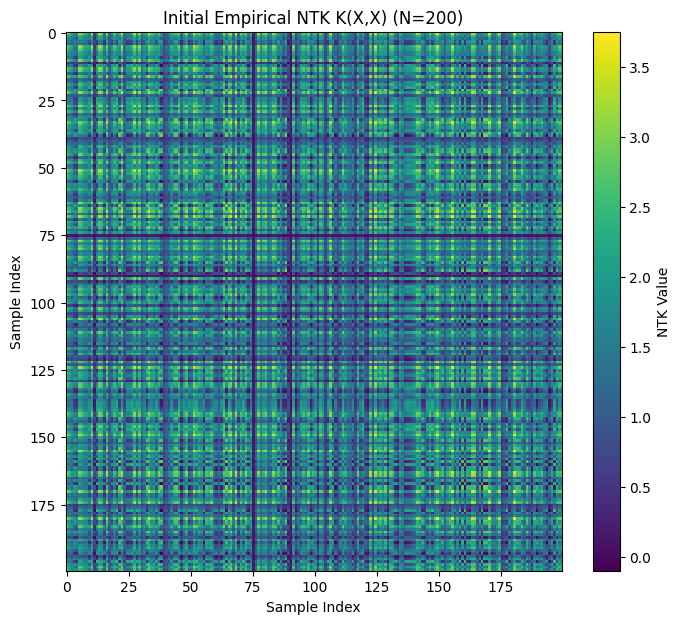

In [9]:
subset_norm = 200
X_ntk_analysis = interior_points[np.random.choice(interior_points.shape[0], subset_norm, replace=False)]

print(f"\n--- Initial Empirical NTK Analysis (on {X_ntk_analysis.shape[0]} training points) ---")
ntk_empirical_initial = analyzer_initial.compute_ntk_dataset(X_ntk_analysis, X_ntk_analysis)
print(f"Shape of Empirical NTK K(X,X): {ntk_empirical_initial.shape}")

# Squeeze the NTK matrix if it has trailing singleton dimensions for plotting
ntk_plot_initial = ntk_empirical_initial
if ntk_empirical_initial.ndim == 4 and ntk_empirical_initial.shape[-1] == 1 and ntk_empirical_initial.shape[-2] == 1:
    ntk_plot_initial = ntk_empirical_initial.squeeze(axis=(-1, -2))
elif ntk_empirical_initial.ndim == 3 and ntk_empirical_initial.shape[-1] == 1 : # Should not happen with current NTKAnalyzer
    ntk_plot_initial = ntk_empirical_initial.squeeze(axis=-1)

plt.figure(figsize=(8,7))
plt.imshow(ntk_plot_initial, cmap='viridis', aspect='auto', interpolation='nearest')
plt.colorbar(label='NTK Value')
plt.title(f'Initial Empirical NTK K(X,X) (N={X_ntk_analysis.shape[0]})')
plt.xlabel('Sample Index')
plt.ylabel('Sample Index')
plt.show()

# Initialize NTKAnalyzer and Analyze at Infinity and Beyond

Number of eigenvalues (initial): 200
Top 5 eigenvalues (initial, largest first): [327.80176    76.021       7.1492276   2.2303872   1.5436985]
Condition Number (initial): 9.6802e+08


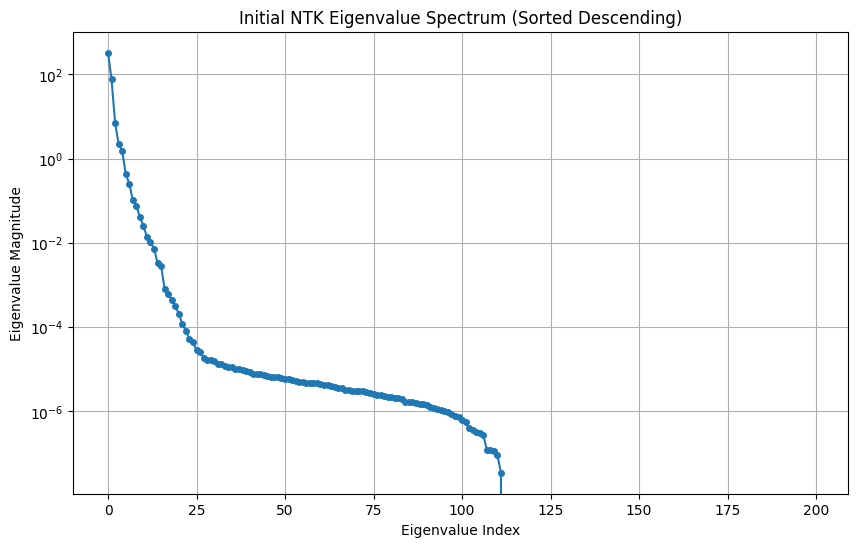


--- Infinite-Width NTK Analysis (on Training Data) ---
Shape of Infinite-Width NTK K_inf(X,X): (200, 200)


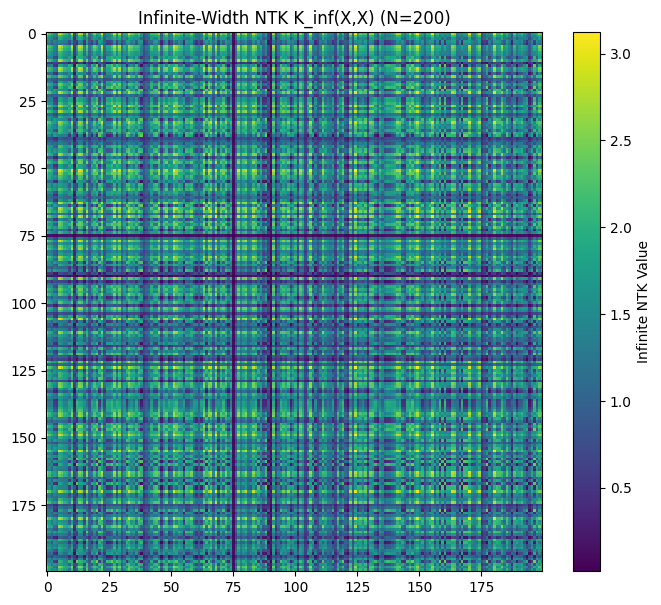

In [ ]:
spectrum_method_choice = "trace" 
try:
    eigenvalues_initial, _ = analyzer_initial.get_ntk_spectrum(X_ntk_analysis, method=spectrum_method_choice)
    print(f"Number of eigenvalues (initial): {len(eigenvalues_initial)}")
    print(f"Top 5 eigenvalues (initial, largest first): {eigenvalues_initial[-5:][::-1]}")
    cond_num_initial = analyzer_initial.get_ntk_condition_number(X_ntk_analysis, method=spectrum_method_choice)
    print(f"Condition Number (initial): {cond_num_initial:.4e}")

    plt.figure(figsize=(10,6))
    plt.plot(jnp.arange(len(eigenvalues_initial)), jnp.sort(eigenvalues_initial)[::-1], 'o-', markersize=4) 
    plt.title('Initial NTK Eigenvalue Spectrum (Sorted Descending)')
    plt.xlabel('Eigenvalue Index')
    plt.ylabel('Eigenvalue Magnitude')
    plt.yscale('log') 
    plt.grid(True, which="both", ls="-")
    plt.show()
except ValueError as e:
    print(f"Error computing initial spectrum: {e}")


print("\n--- Infinite-Width NTK Analysis (on Training Data) ---")
ntk_infinite = analyzer_initial.compute_infinite_ntk_dataset(
    X_ntk_analysis, X_ntk_analysis, kernel_fn=net_stax_kernel_fn
)
if ntk_infinite is not None:
    print(f"Shape of Infinite-Width NTK K_inf(X,X): {ntk_infinite.shape}")
    plt.figure(figsize=(8,7))
    plt.imshow(ntk_infinite, cmap='viridis', aspect='auto', interpolation='nearest')
    plt.colorbar(label='Infinite NTK Value')
    plt.title(f'Infinite-Width NTK K_inf(X,X) (N={X_ntk_analysis.shape[0]})')
    plt.show()

    diff_inf_emp_init = jnp.linalg.norm(ntk_empirical_initial - ntk_infinite)
    print(f"Frobenius norm of difference (Empirical_init - Infinite NTK): {diff_inf_emp_init:.4f}")
    
    eigenvalues_infinite, _ = jnp.linalg.eigh(ntk_infinite) 
    print(f"Top 5 eigenvalues (infinite NTK): {eigenvalues_infinite[-5:][::-1]}")
    abs_eig_inf = jnp.abs(eigenvalues_infinite)
    max_eig_inf = jnp.max(abs_eig_inf)
    # Ensure min_eig_inf_nz is not zero before division
    relevant_eig_inf = abs_eig_inf[abs_eig_inf > 1e-9 * max_eig_inf]
    min_eig_inf_nz = jnp.min(relevant_eig_inf) if relevant_eig_inf.size > 0 else 0.0
    cond_num_inf = jnp.inf if min_eig_inf_nz <= 1e-12 else (max_eig_inf / min_eig_inf_nz)
    print(f"Condition Number (infinite NTK): {cond_num_inf:.4e}")

else:
    print("Could not compute infinite-width NTK.")

print("\n--- Initial NTK Diagonal Properties (on Training Data) ---")
diag_per_output_initial = analyzer_initial.get_ntk_diagonal_per_output(X_ntk_analysis)
if diag_per_output_initial is not None:
    k_ii_initial = diag_per_output_initial[:, 0] 
    print(f"Mean of K(x_i, x_i)_00 (initial): {jnp.mean(k_ii_initial):.4f}")
    print(f"Std Dev of K(x_i, x_i)_00 (initial): {jnp.std(k_ii_initial):.4f}")
    print(f"Variance of K(x_i, x_i)_00 (initial): {jnp.var(k_ii_initial):.4f}")
    if jnp.mean(k_ii_initial) != 0:
        print(f"Relative Std Dev (Std/Mean) of K(x_i, x_i)_00: {(jnp.std(k_ii_initial) / jnp.mean(k_ii_initial)):.4f}")

In [11]:
# Training loop
n_epochs = 500
ntk_iterations = jnp.zeros(((n_epochs // 100) + 1, subset_norm, subset_norm, 1, 1))

print(f"Starting training")
stax_params = init_params.copy()

for epoch in range(1, n_epochs + 1):

    stax_params, opt_state, loss = train_step_stax(stax_params, opt_state, interior_points, boundary_points)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{n_epochs} loss={loss:.4e}")

print("Training finished.")

Starting training
Epoch 100/500 loss=4.2515e+01
Epoch 200/500 loss=2.0103e+01
Epoch 300/500 loss=1.1024e+01
Epoch 400/500 loss=7.3848e+00
Epoch 500/500 loss=5.8163e+00
Training finished.


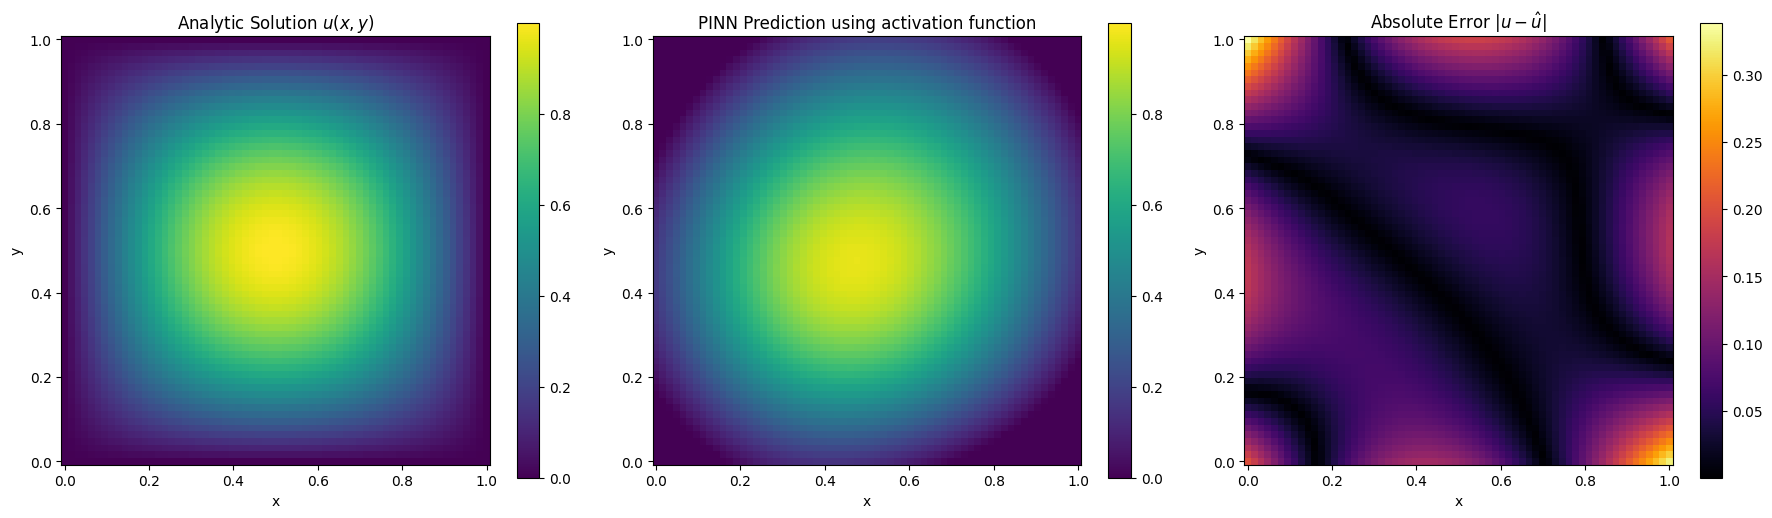

L2 Relative Error: 1.4860e-01


In [12]:
# Evaluation and Plotting
grid_n = 64
t = jnp.linspace(0, 1, grid_n)
xx, yy = jnp.meshgrid(t, t)
# pts will have shape (grid_n*grid_n, 2)
pts_flat = jnp.stack([xx.ravel(), yy.ravel()], axis=-1)

# True solution values
u_true_on_grid = vmap(u_true)(pts_flat).reshape((grid_n, grid_n))

# Predicted solution values
# vmap mlp_predict over all points in pts_flat
u_pred_on_grid = vmap(lambda single_pt: apply_fn(stax_params, single_pt))(pts_flat).reshape((grid_n, grid_n))

# Error
error_on_grid = jnp.abs(u_true_on_grid - u_pred_on_grid)

# Plotting
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.pcolormesh(xx, yy, u_true_on_grid, shading='auto', cmap='viridis')
plt.colorbar()
plt.title('Analytic Solution $u(x,y)$')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('square')

plt.subplot(1, 3, 2)
plt.pcolormesh(xx, yy, u_pred_on_grid, shading='auto', cmap='viridis', vmin=u_true_on_grid.min(), vmax=u_true_on_grid.max()) # same color scale
plt.colorbar()
plt.title(f'PINN Prediction using activation function')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('square')

plt.subplot(1, 3, 3)
plt.pcolormesh(xx, yy, error_on_grid, shading='auto', cmap='inferno')
plt.colorbar()
plt.title('Absolute Error $|u - \hat{u}|$')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('square')

plt.tight_layout()
plt.show()

# Calculate L2 relative error
l2_error_numerator = jnp.sqrt(jnp.sum((u_true_on_grid - u_pred_on_grid)**2))
l2_error_denominator = jnp.sqrt(jnp.sum(u_true_on_grid**2))
l2_relative_error = l2_error_numerator / l2_error_denominator
print(f"L2 Relative Error: {l2_relative_error:.4e}")

# Analysis after training


--- NTK Analysis After Training (on Training Data) ---
Shape of Empirical NTK K(X,X) (trained, raw): (200, 200, 1, 1)


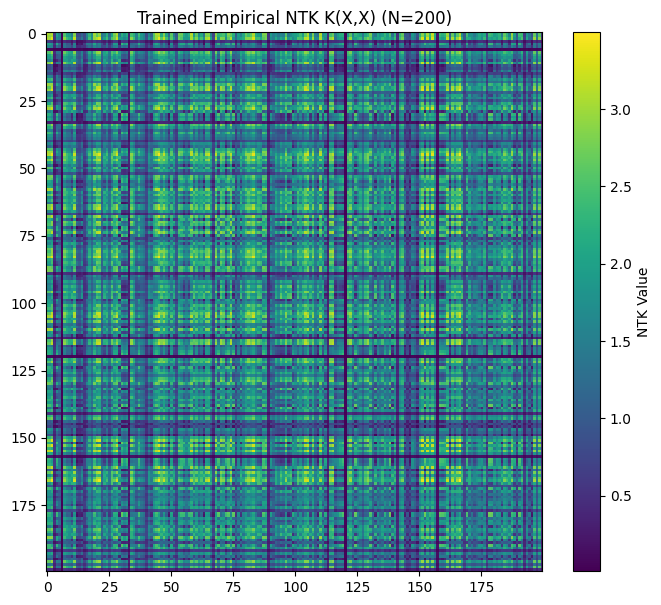

Frobenius norm of NTK change (||K_trained - K_initial||_fro): 15.6809
An unexpected error occurred during trained spectrum analysis: name 'spectrum_method_choice' is not defined

--- Trained NTK Diagonal Properties (on Training Data) ---
Mean of K(x_i, x_i)_00 (trained): 1.9782
Std Dev of K(x_i, x_i)_00 (trained): 0.8756
Variance of K(x_i, x_i)_00 (trained): 0.7667
Relative Std Dev (Std/Mean) of K(x_i, x_i)_00 (trained): 0.4426


In [13]:
print("\n--- NTK Analysis After Training (on Training Data) ---")

analyzer_initial.update_params(stax_params) 

ntk_empirical_trained_raw = analyzer_initial.compute_ntk_dataset(X_ntk_analysis, X_ntk_analysis)
print(f"Shape of Empirical NTK K(X,X) (trained, raw): {ntk_empirical_trained_raw.shape}")

ntk_plot_trained = ntk_empirical_trained_raw
ntk_plot_trained = ntk_empirical_trained_raw.squeeze(axis=(-1,-2))

plt.figure(figsize=(8,7))
plt.imshow(ntk_plot_trained, cmap='viridis', aspect='auto', interpolation='nearest')
plt.colorbar(label='NTK Value')
plt.title(f'Trained Empirical NTK K(X,X) (N={X_ntk_analysis.shape[0]})')
plt.show()

analyzer_for_initial_params = NTKAnalyzer(apply_fn, init_params, HIDDEN_LAYERS, layer_widths_spec)
ntk_change_fro = analyzer_for_initial_params.compute_ntk_change(stax_params, X_ntk_analysis, norm_type='fro')

print(f"Frobenius norm of NTK change (||K_trained - K_initial||_fro): {ntk_change_fro:.4f}")

try:
    eigenvalues_trained, _ = analyzer_initial.get_ntk_spectrum(X_ntk_analysis, method=spectrum_method_choice) 
    print(f"Top 5 eigenvalues (trained): {eigenvalues_trained[-5:][::-1]}")
    cond_num_trained = analyzer_initial.get_ntk_condition_number(X_ntk_analysis, method=spectrum_method_choice)
    print(f"Condition Number (trained): {cond_num_trained:.4e}")

    plt.figure(figsize=(12,7))
    if 'eigenvalues_initial' in locals() or 'eigenvalues_initial' in globals():
        plt.plot(jnp.arange(len(eigenvalues_initial)), jnp.sort(eigenvalues_initial)[::-1], 'o-', label='Initial NTK Eigenvalues', alpha=0.7, markersize=4)
    else:
        print("Warning: eigenvalues_initial not found, skipping its plot.")
    plt.plot(jnp.arange(len(eigenvalues_trained)), jnp.sort(eigenvalues_trained)[::-1], 's-', label='Trained NTK Eigenvalues', alpha=0.7, markersize=4)
    plt.title('Initial vs. Trained NTK Eigenvalue Spectrum')
    plt.xlabel('Eigenvalue Index')
    plt.ylabel('Eigenvalue Magnitude')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, which="both", ls="-")
    plt.show()
except ValueError as e:
    print(f"Error computing trained spectrum: {e}")
except Exception as e: 
    print(f"An unexpected error occurred during trained spectrum analysis: {e}")


print("\n--- Trained NTK Diagonal Properties (on Training Data) ---")
diag_per_output_trained = analyzer_initial.get_ntk_diagonal_per_output(X_ntk_analysis) 
if diag_per_output_trained is not None:
    k_ii_trained = diag_per_output_trained[:, 0] 
    print(f"Mean of K(x_i, x_i)_00 (trained): {jnp.mean(k_ii_trained):.4f}")
    print(f"Std Dev of K(x_i, x_i)_00 (trained): {jnp.std(k_ii_trained):.4f}")
    print(f"Variance of K(x_i, x_i)_00 (trained): {jnp.var(k_ii_trained):.4f}")
    if jnp.mean(k_ii_trained) != 0:
        print(f"Relative Std Dev (Std/Mean) of K(x_i, x_i)_00 (trained): {(jnp.std(k_ii_trained) / jnp.mean(k_ii_trained)):.4f}")